Additive Manutacturing Predictive Quality

 Random Forest Classifier for Audio Classification
 Objective: Train Random Forest with overfitting prevention
 Loading data...
 Data loading completed: 201 samples, 3 features
   Label distribution: Good=50, Defective=151

 Data preprocessing:
   Original training set: 140 samples
   Test set: 61 samples (30%)
   After SMOTE training set: 210 samples
   Balanced label distribution: Good=105, Defective=105

 Training Random Forest classifier:
   Training accuracy: 0.8238 (82.4%)
   Test accuracy:     0.7869 (78.7%)
   Accuracy difference: 0.0369 (3.7%)
   Cross-validation:  0.8333 (±0.062)
   Status:  Good generalization

 Feature importance:
   std_filtered: 0.1966
   hf_ratio: 0.3807
   spectral_centroid: 0.4227

 Detailed performance analysis:
   Confusion matrix: [[36, 10], [ 3, 12]]
   Classification report:
              precision    recall  f1-score   support

   Defective       0.92      0.78      0.85        46
        Good       0.55      0.80      0.65        15

    accurac

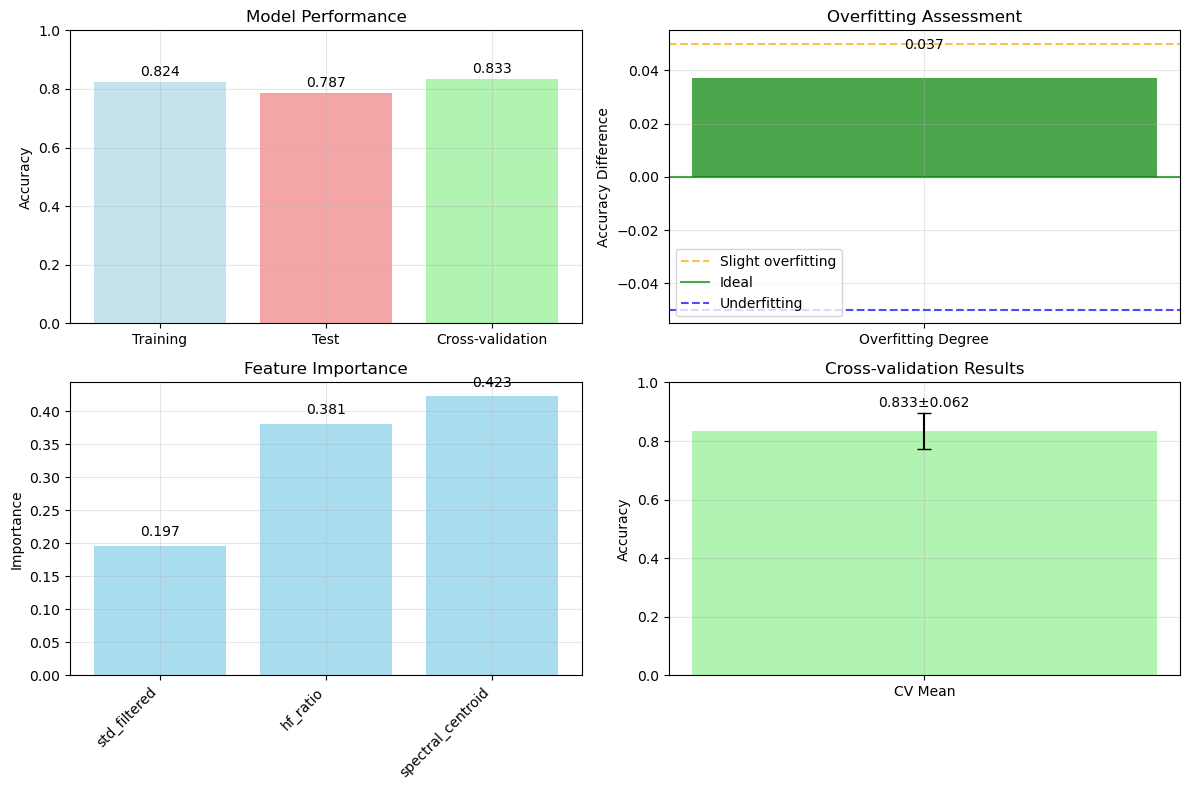


 Random Forest Classification Summary:
 Test accuracy: 0.7869 (78.7%)
 Overfitting control: 0.0369 (3.7%)
 Cross-validation: 0.8333 (±0.062)
 Most important feature: spectral_centroid (0.423)
Overfitting controlled within 5%


In [26]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

def load_audio_data():
    """Load audio feature data from CSV files"""
    folder_path = r"C:\Users\14303\Documents\KIinderProduktionstechnik\PQAM\02_Data"
    
    target_files = {
        'filtered_std_results.csv': 'std_filtered',
        'my_hf_analysis.csv': 'hf_ratio', 
        'my_spectral_analysis.csv': 'spectral_centroid'
    }
    
    print(" Loading data...")
    all_file_data = {}
    
    for filename, feature_name in target_files.items():
        filepath = os.path.join(folder_path, filename)
        if not os.path.exists(filepath):
            continue
            
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        header = [col.strip() for col in lines[0].strip().split(',')]
        
        # Find column indices
        measurement_idx = label_idx = feature_idx = None
        for i, col in enumerate(header):
            col_lower = col.lower().strip()
            if 'measurement' in col_lower or 'number' in col_lower:
                measurement_idx = i
            elif 'label' in col_lower:
                label_idx = i
            elif i not in [measurement_idx, label_idx] and feature_idx is None:
                feature_idx = i
        
        # Parse data
        file_data = {}
        for line in lines[1:]:
            try:
                row = [cell.strip() for cell in line.strip().split(',')]
                if len(row) == len(header):
                    measurement = int(row[measurement_idx])
                    label = row[label_idx]
                    feature_value = float(row[feature_idx])
                    file_data[measurement] = {'label': label, feature_name: feature_value}
            except:
                continue
        
        all_file_data[feature_name] = file_data
    
    # Merge data
    measurement_sets = [set(file_data.keys()) for file_data in all_file_data.values()]
    common_measurements = set.intersection(*measurement_sets)
    
    features = []
    labels = []
    feature_names = list(all_file_data.keys())
    
    for measurement in sorted(common_measurements):
        feature_vector = []
        label = None
        for feature_name in feature_names:
            data = all_file_data[feature_name][measurement]
            feature_vector.append(data[feature_name])
            if label is None:
                label = data['label']
        features.append(feature_vector)
        labels.append(1 if label == 'iO' else 0)
    
    X = np.array(features)
    y = np.array(labels)
    
    print(f" Data loading completed: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"   Label distribution: Good={np.sum(y==1)}, Defective={np.sum(y==0)}")
    
    return X, y, feature_names

def train_random_forest_classifier(X, y, feature_names):
    """Train Random Forest classifier with overfitting prevention"""
    
    # Split data with larger test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Data balancing with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\n Data preprocessing:")
    print(f"   Original training set: {len(X_train)} samples")
    print(f"   Test set: {len(X_test)} samples (30%)")
    print(f"   After SMOTE training set: {len(X_train_balanced)} samples")
    print(f"   Balanced label distribution: Good={np.sum(y_train_balanced==1)}, Defective={np.sum(y_train_balanced==0)}")
    
    # Configure Random Forest with overfitting prevention
    rf_model = RandomForestClassifier(
        n_estimators=10,      # Moderate number of trees
        max_depth=3,          # Limit depth to prevent overfitting
        min_samples_split=20, # Require more samples to split
        min_samples_leaf=8,   # Require more samples in leaf nodes
        max_features='sqrt',  # Use square root of features
        random_state=42,
        class_weight='balanced'
    )
    
    print(f"\n Training Random Forest classifier:")
    print("="*50)
    
    # Training
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    # Prediction
    y_train_pred = rf_model.predict(X_train_balanced)
    y_test_pred = rf_model.predict(X_test_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_balanced, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    diff = train_acc - test_acc
    
    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=5)
    
    print(f"   Training accuracy: {train_acc:.4f} ({train_acc*100:.1f}%)")
    print(f"   Test accuracy:     {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"   Accuracy difference: {diff:.4f} ({diff*100:.1f}%)")
    print(f"   Cross-validation:  {cv_scores.mean():.4f} (±{cv_scores.std():.3f})")
    
    # Overfitting assessment
    if diff > 0.1:
        print(f"   Status:  Overfitting detected")
    elif diff > 0.05:
        print(f"   Status:  Slight overfitting")
    elif diff > -0.05:
        print(f"   Status:  Good generalization")
    else:
        print(f"   Status:  Possible underfitting")
    
    # Feature importance analysis
    feature_importance = rf_model.feature_importances_
    print(f"\n Feature importance:")
    for i, (feature, importance) in enumerate(zip(feature_names, feature_importance)):
        print(f"   {feature}: {importance:.4f}")
    
    # Detailed performance analysis
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\n Detailed performance analysis:")
    print(f"   Confusion matrix: [[{cm[0,0]:2d}, {cm[0,1]:2d}], [{cm[1,0]:2d}, {cm[1,1]:2d}]]")
    print(f"   Classification report:")
    print(classification_report(y_test, y_test_pred, target_names=['Defective', 'Good']))
    
    return rf_model, scaler, X_test_scaled, y_test, {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'diff': diff,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'feature_importance': feature_importance
    }

def plot_results(results, feature_names):
    """Plot training results and feature importance"""
    
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Training vs Test accuracy
    plt.subplot(2, 2, 1)
    categories = ['Training', 'Test', 'Cross-validation']
    accuracies = [results['train_acc'], results['test_acc'], results['cv_mean']]
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    bars = plt.bar(categories, accuracies, color=colors, alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title('Model Performance')
    plt.ylim(0, 1)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Overfitting visualization
    plt.subplot(2, 2, 2)
    diff = results['diff']
    color = 'red' if abs(diff) > 0.1 else 'orange' if abs(diff) > 0.05 else 'green'
    
    plt.bar(['Overfitting Degree'], [diff], color=color, alpha=0.7)
    plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Slight overfitting')
    plt.axhline(y=0.0, color='green', linestyle='-', alpha=0.7, label='Ideal')
    plt.axhline(y=-0.05, color='blue', linestyle='--', alpha=0.7, label='Underfitting')
    
    plt.ylabel('Accuracy Difference')
    plt.title('Overfitting Assessment')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value label
    plt.text(0, diff + 0.01, f'{diff:.3f}', ha='center', va='bottom')
    
    # Subplot 3: Feature importance
    plt.subplot(2, 2, 3)
    importance = results['feature_importance']
    bars = plt.bar(feature_names, importance, color='skyblue', alpha=0.7)
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, imp in zip(bars, importance):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{imp:.3f}', ha='center', va='bottom')
    
    # Subplot 4: Cross-validation scores
    plt.subplot(2, 2, 4)
    cv_mean = results['cv_mean']
    cv_std = results['cv_std']
    
    plt.bar(['CV Mean'], [cv_mean], color='lightgreen', alpha=0.7, 
            yerr=[cv_std], capsize=5)
    plt.ylabel('Accuracy')
    plt.title('Cross-validation Results')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value label
    plt.text(0, cv_mean + cv_std + 0.01, f'{cv_mean:.3f}±{cv_std:.3f}', 
            ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function"""
    print(" Random Forest Classifier for Audio Classification")
    print("="*60)
    print(" Objective: Train Random Forest with overfitting prevention")
    print("="*60)
    
    # Load data
    X, y, feature_names = load_audio_data()
    
    # Train Random Forest classifier
    rf_model, scaler, X_test, y_test, results = train_random_forest_classifier(X, y, feature_names)
    
    # Plot results
    plot_results(results, feature_names)
    
    # Final summary
    print(f"\n" + "="*60)
    print(f" Random Forest Classification Summary:")
    print(f"="*60)
    print(f" Test accuracy: {results['test_acc']:.4f} ({results['test_acc']*100:.1f}%)")
    print(f" Overfitting control: {results['diff']:.4f} ({results['diff']*100:.1f}%)")
    print(f" Cross-validation: {results['cv_mean']:.4f} (±{results['cv_std']:.3f})")
    
    # Find most important feature
    most_important_idx = np.argmax(results['feature_importance'])
    most_important_feature = feature_names[most_important_idx]
    print(f" Most important feature: {most_important_feature} ({results['feature_importance'][most_important_idx]:.3f})")
    
    if abs(results['diff']) <= 0.03:
        print(f" Overfitting controlled within 3%")
    elif abs(results['diff']) <= 0.05:
        print(f"Overfitting controlled within 5%")
    else:
        print(f"Consider further parameter tuning or more data collection")

if __name__ == "__main__":
    main()

